In [2]:
import numpy as np
import math
import os
from google.colab import drive
import cv2
from matplotlib import pyplot as plt

In [3]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')

Mounted at /content/drive


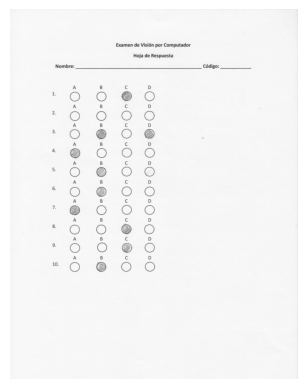

In [4]:
#leer imagen
img = cv2.imread('AI-HR01.jpg')
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#convertir a escala de grises
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#mostrar imagen
plt.imshow(imgGray, cmap='gray')
plt.axis('off')
plt.show()



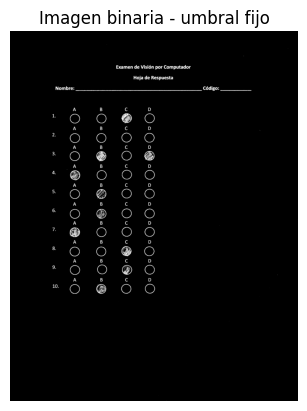

In [5]:
#imagen binaria - umbral fijo
_, thresh = cv2.threshold(imgGray, 190, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.title('Imagen binaria - umbral fijo')
plt.show()


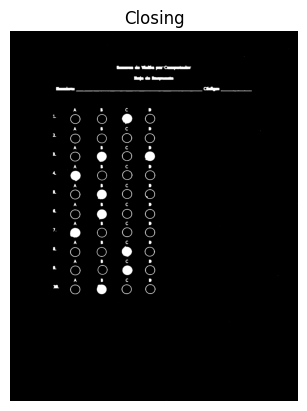

In [6]:
#morphologyEx - closing
kernel = np.ones((4,4), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=4)
plt.imshow(closing, cmap='gray')
plt.axis('off')
plt.title('Closing')
plt.show()

centros de circulos rellenos detectados:
[(810, 2283), (1040, 2118), (1034, 1951), (576, 1789), (812, 1625), (812, 1450), (580, 1282), (812, 1114), (1237, 1110), (1037, 778)]
total circulos rellenos: 10
centros de circulos sin relleno detectados:
[(577, 2287), (810, 2283), (1033, 2286), (1243, 2284), (579, 2120), (1040, 2118), (1241, 2116), (819, 2113), (811, 1955), (576, 1956), (1238, 1953), (1034, 1951), (814, 1784), (576, 1789), (1240, 1782), (1037, 1780), (578, 1623), (812, 1625), (1240, 1620), (1037, 1619), (578, 1447), (812, 1450), (1239, 1444), (1037, 1442), (580, 1282), (815, 1278), (1241, 1277), (1039, 1275), (577, 1111), (812, 1114), (1237, 1110), (1036, 1106), (578, 951), (813, 951), (1239, 947), (1036, 946), (814, 778), (578, 779), (1240, 775), (1037, 778)]
total circulos sin relleno: 40


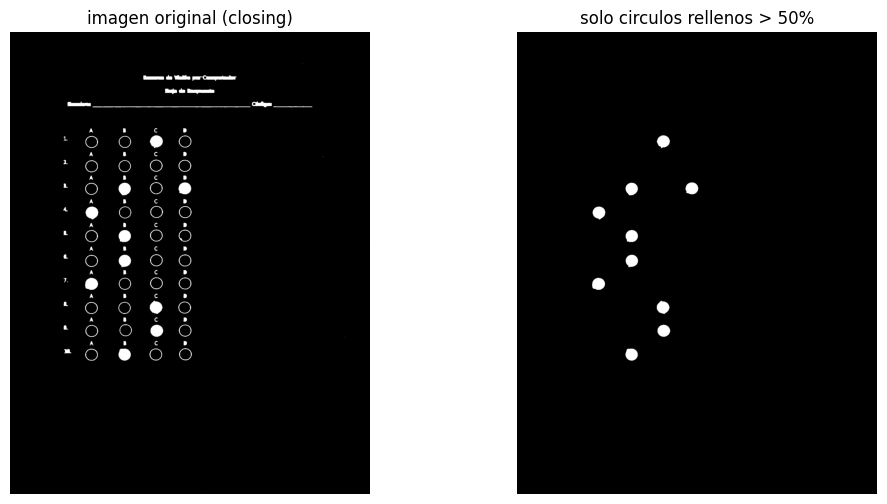

In [7]:
# detectar contornos (aqui no usamos jerarquia porque comprobaremos relleno por porcentaje)
contornos, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# imagen negra donde se pintan los circulos rellenos detectados
rellenos_img = np.zeros_like(closing)

# lista donde guardaremos los centros (x, y) de los circulos validos
centros_rellenos = []
centros_sin_rellenos = []

# parametros de filtro
radio_minimo = 30        # radio minimo en pixeles
circularidad_min = 0.70  # cuanto mas cerca de 1.0 mas circular debe ser
umbral_relleno = 0.5     # porcentaje minimo de relleno (0.5 = 50%)

# recorremos cada contorno detectado
for cnt in contornos:
    # calcular area del contorno
    area = cv2.contourArea(cnt)

    # calcular perimetro (longitud del borde)
    perimetro = cv2.arcLength(cnt, True)

    # obtener el circulo minimo que encierra el contorno
    (x, y), radius = cv2.minEnclosingCircle(cnt)

    # evitar division por cero
    if perimetro == 0:
        continue

    # calcular circularidad usando la formula 4*pi*area/perimetro^2
    circularidad = 4 * np.pi * area / (perimetro * perimetro)

    # aplicar filtros de area, radio y circularidad
    if area > 50 and radius > radio_minimo and circularidad > circularidad_min:
        # crear mascara para este contorno
        mask = np.zeros_like(closing)
        cv2.drawContours(mask, [cnt], -1, 255, -1)

        # contar pixeles blancos dentro del contorno (de la imagen original binarizada)
        pixeles_blancos = cv2.countNonZero(cv2.bitwise_and(closing, closing, mask=mask))
        pixeles_totales = cv2.countNonZero(mask)

        # calcular porcentaje de relleno
        porcentaje_relleno = pixeles_blancos / float(pixeles_totales)
        centros_sin_rellenos.append((int(x), int(y)))
        # si supera el umbral, lo consideramos circulo relleno
        if porcentaje_relleno >= umbral_relleno:
            # dibujar el contorno en la imagen resultado
            cv2.drawContours(rellenos_img, [cnt], -1, 255, -1)
            # guardar el centro (convertido a enteros)
            centros_rellenos.append((int(x), int(y)))

# imprimir resultados
print("centros de circulos rellenos detectados:")
print(centros_rellenos)
print(f"total circulos rellenos: {len(centros_rellenos)}")

print("centros de circulos sin relleno detectados:")
print(centros_sin_rellenos)
print(f"total circulos sin relleno: {len(centros_sin_rellenos)}")

# mostrar imagenes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(closing, cmap='gray')
plt.title('imagen original (closing)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rellenos_img, cmap='gray')
plt.title(f'solo circulos rellenos > {umbral_relleno*100:.0f}%')
plt.axis('off')

plt.show()


Podemos ver que la distancia en vertical (y) de cada circulo a otro circulo debejo de el es aproximadamente de 170, siendo el y mas bajo aproximadamente de 778 siendo esa coordenada la coordenada en (y) de el punto 1 y la del punto 10 seria aprox 2284, entonces la coorenada en y del punto 1 es 778, la del punto 2 seria 778+170, la coordenada del punto 3 en y seria 778+(170 * 2), l del punto 4 seria 778+(170 * 3) asi aproximadamente, con un margen de error de 40 pixeles.

Asi mismo la distancia en x entre cada opcion a, b, c y d es aproximadamente de 230 pixeles con un margen de error de 40 pixeles. la coordenada en x de a es aproximadamente de 576, la de b es de 576+230, la c es 576+(230*2) y asi.

Todo eso sacado al ojo y pruebas jejejeje, pero promediemos cada coordenada tanto de las columnas como de las filas y los margenes de error.

In [8]:
# funcion para agrupar valores cercanos dentro de un margen y devolver el promedio de cada grupo

def agrupar_valores(valores, margen):
    # ordena los valores
    valores = sorted(valores)
    # lista de grupos
    grupos = []
    # inicia el primer grupo
    grupo_actual = [valores[0]]
    for v in valores[1:]:
        # si el valor esta dentro del margen del promedio del grupo actual lo agrega
        if abs(v - np.mean(grupo_actual)) <= margen:
            grupo_actual.append(v)
        else:
            # si no, cierra el grupo y empieza uno nuevo
            grupos.append(grupo_actual)
            grupo_actual = [v]
    # agrega el ultimo grupo
    grupos.append(grupo_actual)
    # devuelve el promedio de cada grupo
    return [int(np.mean(g)) for g in grupos]

# funcion para calcular un margen adecuado basado en las diferencias entre valores consecutivos
def calcular_margen(valores, nombre):
    # ordena los valores
    valores = sorted(valores)
    # calcula diferencias entre valores consecutivos
    difs = [abs(valores[i+1] - valores[i]) for i in range(len(valores)-1)]
    print(f"\ndiferencias consecutivas en {nombre}: {difs}")
    # si no hay diferencias devuelve 0
    if not difs:
        return 0
    # usa la mayor diferencia entre dos grupos y divide
    margen = max(difs) // 3
    print(f"margen calculado para {nombre}: {margen}")
    return margen


In [9]:
# separa xs e ys de los centros
xs = [x for x, y in centros_sin_rellenos]
ys = [y for x, y in centros_sin_rellenos]

# calcula margenes automaticos
margen_x = calcular_margen(xs, "x (columnas)")
margen_y = calcular_margen(ys, "y (filas)")

# agrupa usando el margen calculado
col_prom = agrupar_valores(xs, margen_x)
row_prom = agrupar_valores(ys, margen_y)

# ordena los promedios
col_prom = sorted(col_prom)
row_prom = sorted(row_prom)

# crea diccionario para columnas a b c d
columnas = {chr(97+i): col_prom[i] for i in range(len(col_prom))}
# crea diccionario para filas numeradas
filas = {i+1: row_prom[i] for i in range(len(row_prom))}

print("\ncolumnas (a-d):", columnas)
print("filas (1-10):", filas)



diferencias consecutivas en x (columnas): [0, 1, 0, 1, 0, 0, 0, 1, 1, 230, 1, 1, 0, 0, 1, 1, 0, 1, 4, 214, 1, 2, 0, 1, 0, 0, 0, 2, 1, 197, 1, 1, 0, 1, 0, 0, 1, 0, 2]
margen calculado para x (columnas): 76

diferencias consecutivas en y (filas): [3, 0, 1, 167, 1, 4, 0, 155, 4, 1, 3, 161, 2, 1, 4, 160, 2, 3, 3, 169, 1, 3, 2, 155, 2, 2, 5, 162, 2, 2, 1, 157, 3, 2, 2, 163, 1, 2, 1]
margen calculado para y (filas): 56

columnas (a-d): {'a': 577, 'b': 813, 'c': 1036, 'd': 1239}
filas (1-10): {1: 777, 2: 948, 3: 1110, 4: 1278, 5: 1445, 6: 1621, 7: 1783, 8: 1953, 9: 2116, 10: 2285}


listo ahora ya tengo 2 litas de esas con los promedios de las coordenadas x e y de a-d y de 1-10, ademas tengo los margenes de error de x e y, ahora solo queda crear una matriz de 4 por 20 y llenarla de 0 y poner en 1 las casillas que esten marcadas, dado que ta tenemos una llista con las coordenadas x e y que se llama centros_rellenos, usaremos esas coordenadas para buscar a que fila y columna corresponden.

In [10]:
# crear matriz de 10 filas y 4 columnas llena de ceros
matriz = np.zeros((10, 4), dtype=int)

# recorrer cada centro relleno
for (x, y) in centros_rellenos:
    # buscar columna: comparar x con los promedios de columnas
    for j, col_val in enumerate(col_prom):
        if abs(x - col_val) <= margen_x:
            col_idx = j
            break
    else:
        continue  # si no cae en ningun grupo se salta

    # buscar fila: comparar y con los promedios de filas
    for i, row_val in enumerate(row_prom):
        if abs(y - row_val) <= margen_y:
            row_idx = i
            break
    else:
        continue  # si no cae en ningun grupo se salta

    # marcar en la matriz con 1 (fila, columna)
    matriz[row_idx, col_idx] = 1

# imprimir matriz
print("    a  b  c  d")
for i, fila in enumerate(matriz, start=1):
    print(f"{i:2}| " + "  ".join(str(val) for val in fila))



    a  b  c  d
 1| 0  0  1  0
 2| 0  0  0  0
 3| 0  1  0  1
 4| 1  0  0  0
 5| 0  1  0  0
 6| 0  1  0  0
 7| 1  0  0  0
 8| 0  0  1  0
 9| 0  0  1  0
10| 0  1  0  0


Calculemos la nota suponiendo que nos tenemos los resultados de esta forma
1.   A
2.   B
3.   C
4.   D
5.   D
6.   A
7.  B
8. B
9. A
10. C




In [21]:
#Dar nota
def cambiar_notacion(respuestas_correctas):
  for i in range(len(respuestas_correctas)):
    if respuestas_correctas[i] == 'A':
      respuestas_correctas[i] = 0
    elif respuestas_correctas[i] == 'B':
      respuestas_correctas[i] = 1
    elif respuestas_correctas[i] == 'C':
      respuestas_correctas[i] = 2
    elif respuestas_correctas[i] == 'D':
      respuestas_correctas[i] = 3

def contar_unos(fila):
  contador = 0
  for elemento in fila:
    if elemento == 1:
      contador += 1
  return contador

def calcular_nota(respuestas_correctas):
  if np.all(matriz == 0):
    return 0.1
  else:
    nota = 0
    for i in range(len(matriz)):
      for j in range(len(matriz[0])):
        if matriz[i][j] == 1:
          if respuestas_correctas[i] == j and contar_unos(matriz[i]) < 2:
            nota += 1
          else:
            continue
    return nota


respuestas_correctas = ['C', 'B', 'D', 'A', 'B', 'A', 'A', 'C', 'C', 'B']

cambiar_notacion(respuestas_correctas)

print(f"La nota del estudiante es: {calcular_nota(respuestas_correctas)}")

La nota del estudiante es: 7
